<a href="https://colab.research.google.com/github/kylejwaters/MachineLearning/blob/main/SGD_Applied_to_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying Stochastic Gradient Descent and Backpropagation to Linear Regression

Kyle Waters || 2020

#### How do you go about training a [neural network](https://en.wikipedia.org/wiki/Artificial_neural_network)? In [linear regression](https://en.wikipedia.org/wiki/Linear_regression), estimating a model's parameters is straightforward because there's already a closed-form solution that will give you the optimal estimates (the common approach being [OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares)). However, when estimating the parameters in more complex models like neural nets that lack closed-form solutions, a method like [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) must be used.

## What is Stochastic Gradient Descent?

#### Stochastic gradient descent (SGD) is a varient of gradient descent which is a technique for optimizing a differentiable function. A good analogy to explain gradient descent is a climber ascending a mountain in heavy fog. She hopes to reach the summit (the optimum value) but needs to take incremental steps to get there given the poor visibility. She doesn't know exactly where the summit is but she will assess the incline of her ascent every so often to gather information. Steeper inclines (larger gradients) provide clues for a reasonable path to the top. After a sufficient number of iterations, the hope is that she will reach or be close to the highest point of the mountain and entire mountain range, not a local summit (in optimization, this is the issue of local vs. global maxima). 

![Mountain Top!](https://i2.wp.com/www.skilledroots.com/wp-content/uploads/2018/08/adventure-altitude-backpack-691034.jpg?w=800&ssl=1)

#### Stochastic gradient descent differs from traditional gradient descent by introducing sampling of the training dataset. Instead of using the entire dataset which can be computationally expensive with big data, samples of the data are selected at random in each iteration. Returning to our fearless mountain-climber, this would be like climbing with a trail map that has some random holes in it. On average it will be right, and will probably help speed her ascent, but it might lead her in the wrong direction every so often. Essentially, it introduces a trade off of speed vs. accuracy. 

#### For an intuitive explanantion on gradient descent I recommend checking out this lecture by [Ahmed Hosney](https://ahmedhosny.com/) who researches machine learning and biomedical problems at Dana-Farber Cancer Institute (https://youtu.be/qNOEoAzY168?t=1378).

#### To gain a better understanding of how stochastic gradient descent works in practice, I'll implement it to estimate the coefficients/parameters in a linear regression. 

## I'll start in the very simple setting of a two parameter model, i.e. a line. 

### Our goal is to estimate $\alpha$ and $\beta$ in the model, $$ Y = \alpha + \beta X + \mu, $$ where, $\mu$ ~ N(0,1). 

### Here I'll generate the "true" model which I've arbitrarily chosen to have parameters ($\beta = 2$, $\alpha = 10$).

In [ ]:
''' Import Libraries '''
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x = np.random.normal(0, 1, 5000)
y = 2*x + 10 + np.random.normal(0,1, 5000)

In [ ]:
line = [2*k+10 for k in range(-4, 5, 1)]

### Here's a scatter plot of the dataset with the true data-generating model in red

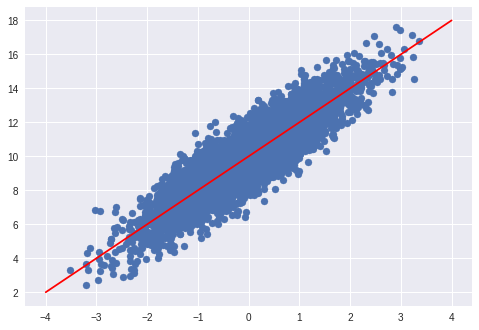

In [ ]:
plt.scatter(x,y)
plt.plot([k for k in range(-4,5,1)], line, 'r')
plt.show()

### We can boil down SGD to five key steps: 

1. Parameter Initialization
 - Choose some random or non-random values to begin with
2. Data Input 
 - Draw a random sample of the data of some specified size, called the batch size
3. Forward Propagation
 - Use the current parameters and calculate the predicted values with those parameters 
4. Loss Calculation
 - Evaluate the predictions with some loss measure, generally the average squared loss for regression problems  
5. Backpropagation and updates to parameter estimates 
 - Calculate and use gradients with respect to the loss to compute better estimates. Return to step 2 and repeat until we reach a specified number of iterations.

### To accomplish step 5, we need to find the gradients associated with each parameter.

We'll define our loss function to be mean squared error. For a training set with $n$ data points this is,

$$ MSE = \frac{1}{n}\sum{(y_{actual} - y_{predicted}) ^ 2} $$

$$ MSE = \frac{1}{n}\sum{(y_{actual} - (\alpha + \beta x)) ^ 2} $$

We'll then take derivatives with respect to each weight. We will focus on the instance of a simple training point ($x_i$, $y_i$). First for alpha, 
$$$$

$$ \frac{\partial{loss}}{\partial{\alpha}} (y_i - (\beta*x_i + \alpha))^2 = -2*(y_i - (\beta*x_i + \alpha)) $$

And for beta, 

$$ \frac{\partial{loss}}{\partial{\beta}} (y_i - (\beta*x_i + \alpha))^2 = -2*x_i*(y_i - (\beta*x_i + \alpha)) $$

Now, we take the mean across these individual training pairs (where n is the batch size), 

$$\frac{1}{n}\sum{-2*(y_i - (\beta*x_i + \alpha))}$$
$$\frac{1}{n}\sum{-2*x_i*(y_i - (\beta*x_i + \alpha))}$$
 
Then, the mean gradient for alpha and beta will be used to update the parameters accordingly. We would like to minimize the loss, so we need to subtract some constant (the learning rate which I'll denote as $\nu$) multiplied by the gradient from the old estimated parameter.

$$\alpha_{new} = \alpha _{old}- \nu * \frac{1}{n}\sum{-2*(y_i - (\beta*x_i + \alpha))}$$
$$\beta_{new} = \beta_{old} - \nu * \frac{1}{n}\sum{-2*x_i*(y_i - (\beta*x_i + \alpha))}$$

The larger the gradient, the more "blame" the parameter will get for the final loss, and it will be updated by a larger amount.

We do this process over and over again "backpropagating" the previous errors to get new weights until we hit a pre-set number of iterations. See (https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Example)

### Now we're ready to define some functions. First we define the model, loss function, and function for finding the gradients as above. 

In [ ]:
def linear_model(x, alpha, beta):
  ''' A simple linear regression model '''
  return(alpha + x*beta)

In [ ]:
def mean_squared_error(y,preds):
  ''' The loss function '''
  return(np.mean((y-preds)**2))

In [ ]:
def calculate_gradients_linear(x,y,alpha,beta):
  ''' Find the gradients with respect to each parameter '''
  d_loss_d_alpha = np.mean(-2*(y-alpha-beta*x))
  d_loss_d_beta = np.mean(-2*x*(y-alpha-beta*x))
  
  return(d_loss_d_alpha, d_loss_d_beta)

### Here, we define the function to accomplish the iterative process of sgd

In [ ]:
def sgd_linear(x, y, learning_rate, batch_size, epochs):
  ''' Perform backpropagation and return the estimated parameters from training'''
  
  ###  Arguments of the Function  ###
    # x is the independent variable of the linear regression
    # y is the dependendent variable of the linear regression
    # learning_rate is the size of the step we take in each iteration to update the weights, higher learning rate = faster training
    # batch_size is the size of the sample of the entire dataset we take at each iteration of the loop to update the weights of the network
    # epochs is the number of iterations through the entire training set
 
  
  
  loops_one_epoch = round(len(y) / batch_size)
  loops_total = loops_one_epoch * epochs
  print("There will be {} loops total".format(loops_total))
  
  # Start by initializing the parameters
  
  alpha = np.random.normal(0,1,1)
  beta = np.random.normal(0,1,1)
  
  # Initialize the following for collecting training stats over time
  losses = []
  betas = []
  alphas = []
  
  alphas.append(alpha)
  betas.append(beta)
  
  # Begin the process of backpropagation
  for iteration in range(loops_total):
    
    # Conduct forward pass with current parameters of the model
    loss = mean_squared_error(y, linear_model(x, alpha, beta))
    losses.append(loss)
    
    print("Our current MSE is: {}".format(loss))
    print("---Calculating gradients---")
    
    # Find the gradients with these current parameters
    gradients = calculate_gradients_linear(x,y,alpha,beta)
    
    # Update the parameters, subtract to minimize loss function
    alpha = alpha - learning_rate*gradients[0]
    beta = beta - learning_rate*gradients[1]
    
    alphas.append(alpha)
    betas.append(beta)
    
    # Recalc. loss with new parameters
    loss = mean_squared_error(y, linear_model(x, alpha, beta))
    print("Our new MSE is: {}".format(loss))
    
  return(alpha, beta, losses, alphas, betas)
    

### Let's see how this performs, I'll start with 2 epochs (iterations through the entire dataset) with a batch size of 50 and a learning rate of 0.05.

In [ ]:
result = sgd_linear(x, y, .05, 50, 2)

### If implemented correctly, we should find that our alpha and beta are close to the truth which is $\alpha = 10$ and $\beta = 2$.

In [ ]:
print('alpha: {}, beta: {}'.format(result[0], result[1]))

alpha: [9.99298237], beta: [1.99896973]


### Woo hoo! We see that we are very close to the true parameters of the model! Let's plot the training loss and parameters over each iteration and see how quickly we converged to values close to the true parameters. 

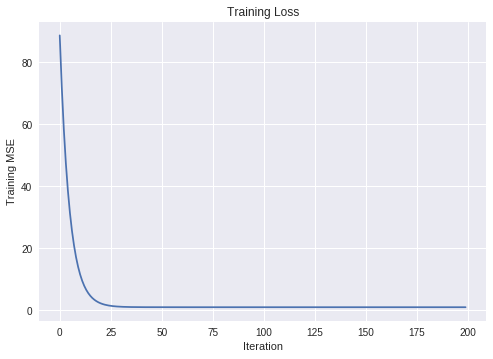

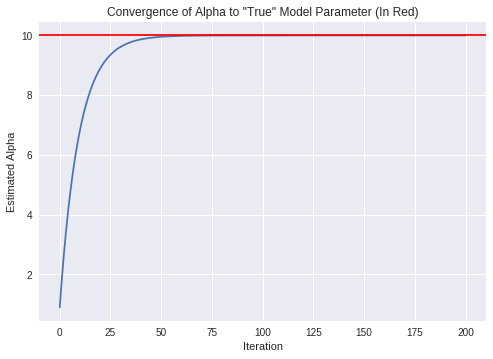

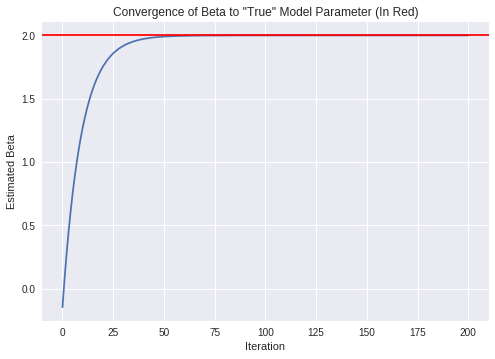

In [ ]:
plt.plot(result[2])
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Training MSE")
plt.show()

plt.plot(result[3])
plt.title('Convergence of Alpha to "True" Model Parameter (In Red)')
plt.xlabel("Iteration")
plt.ylabel("Estimated Alpha")
plt.axhline(y=10, color='r')
plt.show()

plt.plot(result[4])
plt.title('Convergence of Beta to "True" Model Parameter (In Red)')
plt.xlabel("Iteration")
plt.ylabel("Estimated Beta")
plt.axhline(y=2, color='r')
plt.show()

### From these plots, we can see that after around 40 iterations of calculating gradients and updating the parameters we are very close to the true model parameters. 

# Multivariable Linear Regression

### Here, we can generalize SGD to estimating the parameters in a linear model with $j$ right hand side variables. That is, the model, 

$$ Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_j X_j  + \mu$$

### The math doesn't change very much for calculating the gradients. We will just need to implement a few dot products in the code.

The gradients will be,

$$ \frac{\partial{MSE}}{\partial{\alpha}} = \frac{1}{n}\sum_{i=1}^{n}{-2*(y_i - \alpha - \sum_{k=1}^{j}\beta_{k}*x_{ki})} $$

$$ \frac{\partial{MSE}}{\partial{\beta_j}} = \frac{1}{n}\sum_{i=1}^{n}{-2*x_{ij}(y_i - \alpha - \sum_{k=1}^{j}\beta_{k}*x_{ki})} $$

### Here, we define the model and the function to calculate the gradients as above.

In [ ]:
def multivariate_model(X, bias, weights):
  return(np.dot(X, weights)+ bias)

In [ ]:
def calculate_gradients(X, y, bias, weights):
  d_loss_d_bias = np.mean(-2*(y-bias-np.dot(X, weights)))
  
  d_loss_d_weights = []
  
  for var in range(len(weights)):
    
    d_loss_d_weight = np.mean(-2*X[:, var]*(y-bias-np.dot(X, weights)))
    d_loss_d_weights.append(d_loss_d_weight)
  
  return(d_loss_d_bias, np.array(d_loss_d_weights))                   

### Next, we define the function to conduct stochastic gradient descent with a multivariable linear regression.

In [ ]:
def sgd_multivariable(X, y, learning_rate, batch_size, epochs):
 

    ###  Arguments of the Function  ###
    # X is the independent variable(s) of the linear regression
    # y is the dependendent variable of the linear regression
    # learning_rate is the size of the step we take in each iteration to update the weights, higher learning rate = faster training
    # batch_size is the size of the sample of the entire dataset we take at each iteration of the loop to update the weights of the network
    # epochs is the number of iterations through the entire training set

    
  loops_one_epoch = round(len(y) / batch_size)
  loops_total = loops_one_epoch * epochs
  print("There will be {} loops total".format(loops_total))
  
  # Begin with initializing parameters, and conduct the forward pass
  
  bias = np.random.normal(1,0,1)
  weights = np.random.normal(0,1,[X.shape[1]])
  
  
  # Initialize the following for collecting training stats over time
  losses = []
  weights_ = []
  alphas = []
  
  alphas.append(bias)
  weights_.append(weights)
  
  # Begin backpropagation algorithm
  
  for k in range(loops_total):
    
     # Forward Pass
    loss = mean_squared_error(y, multivariate_model(X, bias, weights))
    losses.append(loss)
    
    print("Current MSE: {}".format(loss))
    
    # Calculate gradients, update weights 
    print("---Calculating Gradients...")
    
    gradients = calculate_gradients(X, y, bias, weights)
    
    #Update weights/bias
    bias = bias - learning_rate * gradients[0]
    weights = weights - learning_rate*gradients[1]
    
    weights_.append(weights)

    loss = mean_squared_error(y, multivariate_model(X, bias, weights))
    print("New MSE: {}".format(loss))
    losses.append(loss)
    
  return(bias, weights, losses, weights_, alphas)

### Let's see how this works. I'll create a dummy test dataset with five independent variables with the parameters $\beta_1 = 1, \beta_2 = 2, \beta_3 = 3, \beta_4 = 4, \beta_5 = 5$, and  $\alpha=10$ as below, 

$$ Y = 10 + 1X_1 + 2X_2 + 3X_3 + 4X_4 + 5X_5 + \mu$$

### where, $\mu$ ~ N(0,1). 

In [ ]:
# Dummy test dataset

X = np.random.normal(0,1,[5000,5])
true_betas = [1,2,3,4,5]
y = 10 + np.dot(X, true_betas) + np.random.normal(0,1,5000)

In [ ]:
results = sgd_multivariable(X,y,.10,50,1)

## Evaluation
### If correctly done, we will find the weights/betas close to the actual values of 1,2,3,4,5 and the bias/alpha close to 10.

In [ ]:
print("weights:{} , bias:{}".format(results[1], results[0]))

weights:[1.00709498 1.98711771 2.98828633 3.98337715 4.99867249] , bias:[9.9907781]


### Which they are!

## Here is a plot of the training error (mean squared error) over time. 

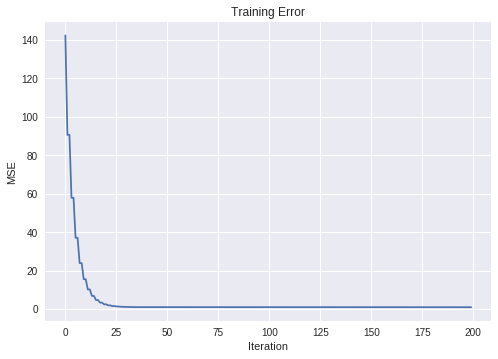

In [ ]:
plt.plot(results[2])
plt.title('Training Error')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.show()

## Here are the plots of the estimated betas over time 

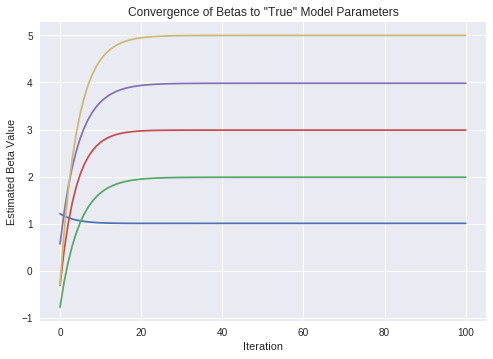

In [ ]:
plt.plot(results[3])
plt.title('Convergence of Betas to "True" Model Parameters')
plt.xlabel("Iteration")
plt.ylabel("Estimated Beta Value")
plt.show()

### It certainly helped that the initial value for the first parameter was close to 1. In fact, most of these values converge quickly because the initialized parameters were so close to the truth. In the common analogy of gradient descent being like climbing up a mountain in heavy fog, this is the equivalent of being dropped off by a helicopter half way to the summit. So there is little additional effort needed to reach the top (i.e. reach the max value/optimum). As we can see, initialization can play a big role in the performance of stochastic gradient descent. 

# Conclusion 

### Stochastic gradient descent is a powerful method for estimating parameters and as expected, performs quite well with the nicely-behaved linear model. It is also not too difficult to implement, making it a popular choice for training many machine learning models. 